# PWHL Skater Statistics for the Current Season

## Overview

This notebook shows how to create a dataset from PWHL skater statistics and save it as a CSV file.

## Setup
Decomment any of the following lines to install the corresponding packages.

In [2]:
#!pip install html5lib
#!pip install lxml
#!pip install selenium

Import all required libraries/packages.

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Define the webscraping function.

**NOTE:** A WebDriver must be installed for this to work. See [Selenium’s download page](https://www.selenium.dev/downloads/) for details. If not using Edge, edit the third line of the following cell.

In [6]:
def scrape_stats_page(url):
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge
    # open the webpage
    driver.get(url)
    # wait for the table to load
    try:
        table = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, '//table'))
        )
        rows = table.find_elements(By.TAG_NAME, 'tr')
        data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, 'td')
            data.append([col.text for col in cols])
        df = pd.DataFrame(data)
    finally:
        driver.quit()
    return df

## Webscraping
First, get the information from the player statistics table on the league’s website.

The page doesn’t load the table immediately so there is a delay before scraping the data. Wait for the completion message before trying to use `df`.

In [8]:
for i in range (1, 8):
    page_url = "https://www.thepwhl.com/en/stats/player-stats/all-teams/5?sort=points&playertype=skater&position=skaters&rookie=no&statstype=expanded&page=" + str(i) + "&league=1"
    page_df = scrape_stats_page(page_url)
    if ("temp_df" not in globals()):
        temp_df = page_df
    else:
        temp_df = pd.concat([temp_df, page_df])
df = temp_df
del temp_df
print("Webscraping complete.")

Webscraping complete.


Then, do the same for each team’s player details page.

The page doesn’t load the table immediately so there is a delay before scraping the data. Wait for the completion message before trying to use `det_df`.

In [10]:
for i in range (1, 7):
    page_url = "https://www.thepwhl.com/en/stats/roster/" + str(i) + "/5?league=1"
    page_df = scrape_stats_page(page_url)
    if ("temp_df" not in globals()):
        temp_df = page_df
    else:
        temp_df = pd.concat([temp_df, page_df])
det_df = temp_df
del temp_df
print("Webscraping complete.")

Webscraping complete.


You should now have two dataframes, `df` and `det_df`, containing player statistics and details, respectively.

## Data cleaning and formatting

First, give a name to each column. Then, and drop (remove) useless columns.

In [13]:
# statistics dataframe
df.columns = ["rank", "status", "photo", "name", "position",
              "team", "games played", "goals", "assists", "points",
              "plus/minus", "penalty minutes", "power play goals", "power play assists", "short handed goals",
              "shots", "short handed assists", "game winning goals", "first goals", "insurance goals",
              "overtime goals", "unassisted goals", "empty net", "shooting percentage", "shootout goals",
              "shots in shootouts", "shootout winning goals", "shootout percentage", "nothing"]
df.drop(columns=["photo", "nothing", "position"], inplace=True) #photo and nothing are just blank spaces in the table; the photos are loaded separately
                                                                #the position is covered by the details dataframe
# details dataframe
det_df.columns = ["jersey number", "name", "position", "shoots", "date of birth", "hometown", "nothing"]
det_df.drop(columns=["nothing"], inplace=True) #this one is just blank space in the table

In the statistics table on the PWHL website, players who switched teams during the season have " +" after their name. The plus sign is used as a button to access the player’s statistics with each team. Remove these extra characters so each player’s name is identical in both dataframes.

In [15]:
# Removing " +"
df["name"] = df["name"].str.replace(" +", "")

Blank lines from each dataframe prior to joining them. Otherwise, the lines with no data would all match each other and the resulting merged dataframe would contain thousands of rows.

In [17]:
df.dropna(inplace = True)
det_df.dropna(inplace = True) #removing blank lines

You can now use the player names to join the dataframes.

In [19]:
skaters_df = df.merge(det_df, on="name")
skaters_df

,rank,status,name,team,games played,goals,assists,points,plus/minus,penalty minutes,...,shooting percentage,shootout goals,shots in shootouts,shootout winning goals,shootout percentage,jersey number,position,shoots,date of birth,hometown
0,1,*,Sarah Fillier,NY,14,5,10,15,4,10,...,12.8,0,3,0,0.0,10,F,R,2000-06-09,"Georgetown, ON"
1,2,,Kendall Coyne Schofield,MIN,15,6,8,14,8,2,...,13.0,0,0,0,0.0,26,F,L,1992-05-25,"Palos Heights, IL"
2,3,,Taylor Heise,MIN,14,4,10,14,1,0,...,8.7,2,5,1,40.0,27,F,R,2000-03-17,"Lake City, MN"
3,4,,Claire Thompson,MIN,15,3,11,14,2,4,...,16.7,1,2,1,50.0,42,D,L,1998-01-28,"Toronto, ON"
4,5,,Hannah Miller,TOR,15,7,6,13,4,0,...,21.2,0,2,0,0.0,34,F,L,1996-02-16,"North Vancouver, BC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,,Maddie Rooney,MIN,9,0,0,0,0,0,...,0.0,0,0,0,0.0,35,G,L,1997-07-07,"Andover, MN"
136,137,,Ann-Renée Desbiens,MTL,10,0,0,0,0,2,...,0.0,0,0,0,0.0,35,G,L,1994-04-10,"Clermont, QC"
137,138,,Aerin Frankel,BOS,10,0,0,0,0,0,...,0.0,0,0,0,0.0,31,G,L,1999-05-24,"Chappaqua, NY"
138,139,,Corinne Schroeder,NY,10,0,0,0,0,0,...,0.0,0,0,0,0.0,30,G,L,1999-08-17,"Elm Creek, MB"


On occasion, goaltenders may be awarded assists or even score goals. They are therefore included in skater rankings. However, their role on the ice and therefore their statistics greatly differ from that of other players. They are outliers in almost every aspect.

For this reason, I chose to exclude goalies from the dataset.

In [21]:
skaters_df = skaters_df[skaters_df["position"] != "G"] #removing goalies

Then, edit a few textual values to make them clearer.

In [23]:
# The status column contains an asterisk for a rookie and an X for an inactive player
# Changing them to words for clarity
pd.options.mode.copy_on_write = True
is_rookie = (skaters_df["status"] == "*")
is_inactive = (skaters_df["status"] == "x")
skaters_df.loc[is_rookie, "status"] = "rookie"
skaters_df.loc[is_inactive, "status"] = "inactive"

In [24]:
# Boston gives more specific values for the position, like "LW" for "left wing" or "C" for "center"
# Not retaining that information since the other teams just have "F" and "D"

# Changing all position values to "forward" and "defense" for clarity
pd.options.mode.copy_on_write = True
forward = skaters_df["position"].isin(["F", "RW", "C", "LW"])
defense = skaters_df["position"].isin(["D", "RD", "LD"])
skaters_df.loc[forward, "position"] = "forward"
skaters_df.loc[defense, "position"] = "defense"

In [25]:
# Changing "L" and "R" in the "shoots" column to "left" and "right" for clarity
pd.options.mode.copy_on_write = True
left = (skaters_df["shoots"] == "L")
right = (skaters_df["shoots"] == "R")
skaters_df.loc[left, "shoots"] = "left"
skaters_df.loc[right, "shoots"] = "right"

The "hometown" column has each player’s hometown in the following format: `<town name>, <code>`. The code is that of the state, province or territory when in the United States and Canada. Otherwise, the code is that of the country.

In [27]:
skaters_df[['hometown','hometown location']] = skaters_df["hometown"].str.split(", ", expand=True)

The dataframe has a birthdate column. Use it to add an age column.

In [29]:
# function to return the age, in years, rounded down
def calculate_age(birthdate_str):
    birthdate = pd.to_datetime(birthdate_str)
    today = pd.to_datetime('today')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age
# create a row for the age in years
skaters_df["age"] = skaters_df.apply(lambda row: calculate_age(row["date of birth"]), axis = 1)

In [70]:
#TODO
#add home country column

## Saving to CSV

In [49]:
skaters_df.to_csv("skater_stats.csv", index=False)

## Example visualization: points per rookie per team

In [51]:
# define team names, location, codes and colors
teams = {"BOS": {"name": "Fleet", "location": "Boston", "code": "BOS", "color":"#173f35"},
         "MIN": {"name": "Frost", "location": "Minnesota", "code": "MIN", "color":"#251161"},
         "MTL": {"name": "Victoire", "location": "Montréal", "code": "MTL", "color":"#832434"},
         "NY": {"name": "Sirens", "location": "New York", "code": "NY", "color":"#00bcb5"},
         "OTT": {"name": "Charge", "location": "Ottawa", "code": "OTT", "color":"#a3142f"},
         "TOR": {"name": "Sceptres", "location": "Toronto", "code": "TOR", "color":"#1869b7"}}

In [64]:
# converting points to numeric format
skaters_df["points"] = pd.to_numeric(skaters_df["points"])

In [66]:
def points_per_rookie(df, team_code):
    rookie_points = (df[(df["status"] == "rookie") & (df["team"] == team_code)])["points"] #only keeps the rookies from the specified team
    return rookie_points.sum() / rookie_points.count() # total points divided by number of rookies

colors = []
pprookie_data = []

# creating the colors and pprookie_data lists
for team, details in teams.items():
    pprookie_data.append((team, points_per_rookie(skaters_df, team)))
    colors.append(details["color"])

# turning the pprookie_data list into a DataFrame
pprookie_df = pd.DataFrame(pprookie_data)
# naming the columns
pprookie_df.columns = ["team", "points per rookie"]
pprookie_df

,team,points per rookie
0,BOS,4.250000
1,MIN,2.375000
2,MTL,4.600000
3,NY,5.166667
4,OTT,3.666667
5,TOR,1.833333


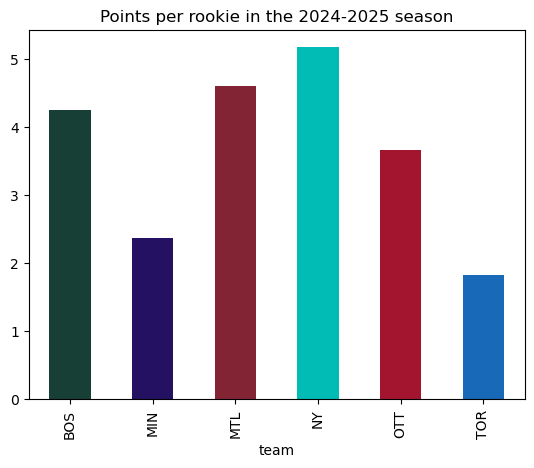

In [68]:
pprookie_df.plot.bar(x="team", y="points per rookie", color=colors, title="Points per rookie in the 2024-2025 season", legend=None)
plt.show()

## Notes

* The number of rows in the output file may vary as players may join the league during the season.
* The highest player rank may be higher than the number of rows in the CSV file as goalies may also score points and obtain a rank, but are removed from this dataset.